       fold  mag    grp                                           filename
0         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[39545 rows x 4 columns]
   fold  mag    grp                                               path  \


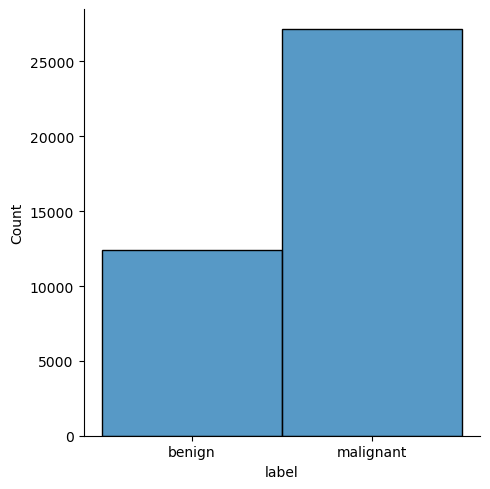

['benign', 'malignant']
{'benign': 0, 'malignant': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8583508644104004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9005881843566894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
Clip

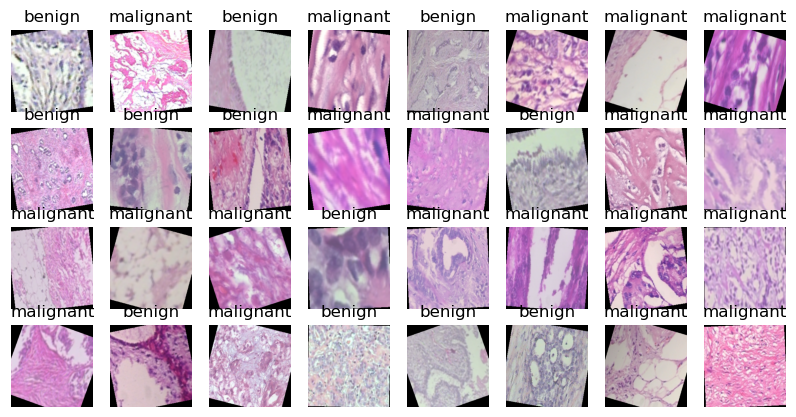

train   :  25880
vali :  10932
test :  2733


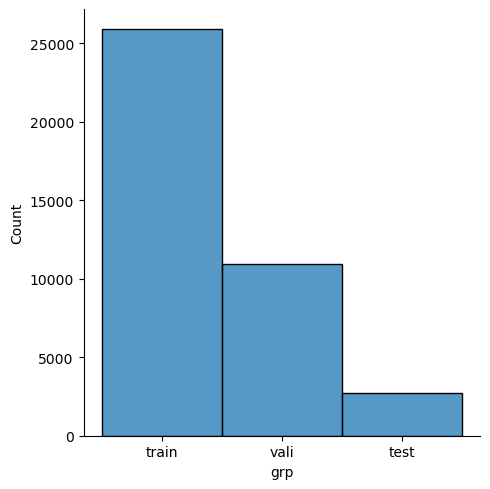

grp
train    25880
vali     10932
test      2733
Name: count, dtype: int64


In [1]:
#correr las librerias del notebook de preprocesamiento del dataset 

%run  dataset_preprocessing.ipynb

In [2]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(dim, heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(), # funcion de activacion que normaliza la entrada de los datos 
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        mlp_output = self.mlp(x)
        x = self.norm2(x + mlp_output)
        return x

In [3]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout=0.1):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size

        self.patch_size=patch_size
  

        self.patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 3, 224, 224)
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, -1, self.patch_size * self.patch_size * 3)
        x = self.patch_embedding(x)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :x.size(1)]
        x = self.dropout(x)

        x = x.permute(1, 0, 2)  # Necesario para MultiheadAttention
        x = self.transformer_blocks(x)
        x = x[0]

        x = self.mlp_head(x)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(
    image_size=224, #Tamaño de la imagen
    patch_size=16,
    num_classes=2,
    dim=768, # dimension del embbeding
    depth=4, # cantidad de bloques de Transfomers del modelo 
    heads=4, # numero de cabezas de atencion del modelo
    mlp_dim=500, # numero de capas feedfordward 768x4
    dropout=0.1
).to(device)

model= model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)

In [5]:
input_size = (3, 224, 224)
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 196, 768]         590,592
           Dropout-2             [-1, 197, 768]               0
MultiheadAttention-3  [[-1, 2, 768], [-1, 197, 197]]               0
         LayerNorm-4               [-1, 2, 768]           1,536
            Linear-5               [-1, 2, 500]         384,500
              GELU-6               [-1, 2, 500]               0
            Linear-7               [-1, 2, 768]         384,768
           Dropout-8               [-1, 2, 768]               0
         LayerNorm-9               [-1, 2, 768]           1,536
 TransformerBlock-10               [-1, 2, 768]               0
MultiheadAttention-11  [[-1, 2, 768], [-1, 197, 197]]               0
        LayerNorm-12               [-1, 2, 768]           1,536
           Linear-13               [-1, 2, 500]         384,500
             GELU-14        

In [6]:
# Verifica si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

Usando el dispositivo: cuda


In [ ]:
# Listas para almacenar las pérdidas
train_losses = []
val_losses = []

epoch = 20

# Entrenar el modelo
def train_model(model, train_loader, vali_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Bucle de entrenamiento
        for inputs, labels in train_loader:
            # Mover datos a la GPU si está disponible
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # Acumular pérdida ponderada por tamaño de lote

        # Calcular la pérdida promedio de entrenamiento por época
        epoch_train_loss = running_loss / len(train_loader.dataset)  # Dividir por el número total de ejemplos
        train_losses.append(epoch_train_loss)
        
        # Fase de validación
        val_loss = 0.0
        model.eval()  # Establecer el modo de evaluación
        correct_predictions = 0

        with torch.no_grad():
            for inputs, labels in vali_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)  # Ponderar por el tamaño del lote
                
                # Calcular el número de predicciones correctas
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)

        # Calcular la pérdida de validación promedio por época
        epoch_val_loss = val_loss / len(vali_loader.dataset)  # Dividir por el número total de ejemplos
        val_losses.append(epoch_val_loss)

        # Calcular precisión en la validación
        accuracy = correct_predictions.double() / len(vali_loader.dataset)

        # Imprimir las pérdidas y la precisión
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.4f}')
        
# Llamar la función para entrenar el modelo
train_model(model, train_loader, vali_loader, criterion, optimizer, num_epochs=epoch)

In [ ]:
# Graficar las pérdidas
def plot_losses(train_losses, val_losses):
    # Usar el tamaño más pequeño entre train_losses y val_losses para los epochs
    epochs = range(1, min(len(train_losses), len(val_losses)) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses[:len(epochs)], label='Training Loss')  # Asegurarse de que los tamaños coincidan
    plt.plot(epochs, val_losses[:len(epochs)], label='Validation Loss')  # Cortar si hay más valores
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar después del entrenamiento
plot_losses(train_losses, val_losses)

In [ ]:
#Probar el modelo 
def test_model(model, vali_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in vali_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    accuracy = correct_predictions / total_samples
    print(f'Accuracy on test set: {accuracy:.4f}')

# Llama a la función de prueba del modelo
test_model(model, vali_loader)

In [ ]:
# Guardar el estado del modelo
torch.save(model, 'ViT_base.pth')

In [ ]:
#cargar el modelo, agregar la direccion  del directori donde se guardo 

model=torch.load( '/archive//ViT_base.pth')

In [ ]:
#librerias para realizar la matriz de confusion

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Etiquetas verdaderas y predicciones del modelo
y_true = []
y_pred = []

# Desactivar gradientes para el cálculo (modo evaluación)
with torch.no_grad():
    for data in test_loader:  # Se usa el dataset  test ya definido anteriormente
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Obtener predicciones
        outputs = model(inputs)

        # Si la salida es un objeto ImageClassifierOutput, accede a los logits:
        outputs = outputs.logits if hasattr(outputs, 'logits') else outputs
        _, predicted = torch.max(outputs, 1)

        # Guardar las etiquetas reales y predichas
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión DeiT-Tiny')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Nombres de las etiquetas
class_names = ['Benigno', 'Maligno']

# Generar la matriz de confusión (supongamos que ya tienes las predicciones y etiquetas verdaderas)
cm = confusion_matrix(y_true, y_pred)

# Configurar el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)

# Etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión ViT base')
plt.show()